# W207 Final Project: Facial Keypoint Detection
#### Authors: Amy Jung, Gabriel Louis-Kayen, Jeremy Yeung, Shanie Hsieh, and Simran Sachdev
---
# Part 2: Convolutional Neural Network

Data: https://www.kaggle.com/c/facial-keypoints-detection/data

## Import Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, Dropout, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from PIL import Image, ImageOps

We will use the below cell to get reproducible results.

In [ ]:
''' GET REPRODUCIBLE RESULTS https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras'''
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

## Import and Preprocess Dataset

Read data in from csv, use the 4 main keypoints, extract image arrays from dataframe, and split into training and test sets.

In [ ]:
# read in data
train = pd.read_csv("data/training.csv")

# filter columns
selected_columns = train[["left_eye_center_x", "left_eye_center_y", "right_eye_center_x", "right_eye_center_y", "nose_tip_x", "nose_tip_y", "mouth_center_bottom_lip_x", "mouth_center_bottom_lip_y", "Image"]]
train_4 = selected_columns.copy()

# drop 49 rows
train_4 = train_4.dropna()

# transform all image data to correct shape
train_data = []
for img in train_4.dropna(axis=0).Image:
    img = img.split()
    img = [int(i) for i in img]
    img = np.array(img)
    train_data.append(img.reshape(96, 96, 1))
train_data = np.array(train_data)
train_labels = train_4.iloc[:, :8].to_numpy()

# train test split
train_model_data, test_model_data = train_test_split(train_data, test_size=0.2)
train_model_labels, test_model_labels = train_test_split(train_labels, test_size=0.2)

# mini train data to see model performance
mini_train_data = train_data[:100]
mini_train_labels = train_labels[:100]

print("Train shape:", train_model_data.shape, train_model_labels.shape)
print("Test shape:", test_model_data.shape, test_model_labels.shape)

Train shape: (5600, 96, 96, 1) (5600, 8)
Test shape: (1400, 96, 96, 1) (1400, 8)


## Model 1

*activation function ReLU*

ReLU stands for rectified linear unit activation function where y = max(0,x). It is the most commonly used activation function in neural networks, especially CNNs. And because ReLU is linear for all positive values and zero for all negative values, it has these characteristics:
- cheap to compute (no complicated math). Therefore, the model takes less time to train/run.
- coverges faster. Linearity prevents the vanishing gradient problem when the x gets large since the slope does not plateau (unlike sigmoid or tanh activation functions).
- sparsely activated. Because ReLU is zero for all negative inputs, any given unit may not activate at all. This is desirable because data sparsity results in concise models that hvae better predictive power and less overfitting/noise. 

**References** \
https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7

Flatten() - removes all of the dimensions except for one. 

Dense() - this is a fully connected layer which takes in the pixel values after they are flattened.

Epoch 1/4
4/4 [==============================] - 11s 2s/step - loss: 2230332.2500 - mae: 904.1334
Epoch 2/4
4/4 [==============================] - 11s 2s/step - loss: 6191.0674 - mae: 69.7573
Epoch 3/4
4/4 [==============================] - 10s 2s/step - loss: 2836.9387 - mae: 50.5827
Epoch 4/4
4/4 [==============================] - 10s 2s/step - loss: 2717.2791 - mae: 49.1129


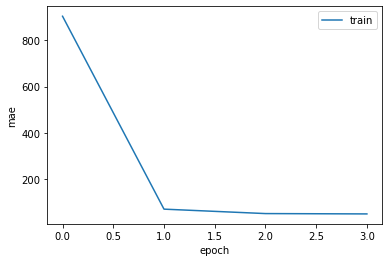

In [ ]:
#create model
model_1 = Sequential()

#add model layers
model_1.add(Conv2D(256, kernel_size=3, activation='relu', input_shape=(96,96,1)))
model_1.add(Conv2D(64, kernel_size=3, activation='relu'))
model_1.add(Flatten())
model_1.add(Dense(8))

#compile model using accuracy to measure model performance
model_1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# get the history so we can see progress
history_1 = model_1.fit(mini_train_data, mini_train_labels, epochs=4)

plt.plot(history_1.history['mae'], label='train')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend()

## Model 2
MaxPooling2D()

Max Pooling finds the largest value in each patch of each feature map. For image classification, MaxPooling has been found to work better than average pooling. It downsamples the input along its spatial dimensions by taking the max value over an input window for each channel of the input. The size of the input window is defined by a tuple pool_size (height x width). In this model we are using a pool size of (2,2) so we will take the max value over a 2x2 window.

Reference: https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/

Epoch 1/50
3/3 [==============================] - 1s 264ms/step - loss: 16589.8828 - mae: 94.1110 - val_loss: 4312.1357 - val_mae: 54.0651
Epoch 2/50
3/3 [==============================] - 1s 199ms/step - loss: 4186.7803 - mae: 57.6447 - val_loss: 3268.5330 - val_mae: 53.3740
Epoch 3/50
3/3 [==============================] - 1s 200ms/step - loss: 2889.4451 - mae: 49.8429 - val_loss: 2093.5269 - val_mae: 41.1032
Epoch 4/50
3/3 [==============================] - 1s 199ms/step - loss: 2039.7849 - mae: 40.7333 - val_loss: 1816.2330 - val_mae: 37.4698
Epoch 5/50
3/3 [==============================] - 1s 198ms/step - loss: 1812.6323 - mae: 37.7425 - val_loss: 1636.3606 - val_mae: 35.0789
Epoch 6/50
3/3 [==============================] - 1s 199ms/step - loss: 1640.1567 - mae: 34.8642 - val_loss: 1346.8588 - val_mae: 31.0496
Epoch 7/50
3/3 [==============================] - 1s 197ms/step - loss: 1213.5378 - mae: 30.1972 - val_loss: 718.8055 - val_mae: 23.0410
Epoch 8/50
3/3 [==================

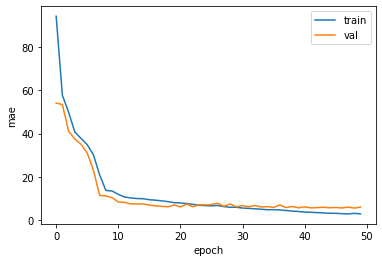

In [ ]:
model_2 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(96,96,1)),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dense(8)
])

model_2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

history_2 = model_2.fit(mini_train_data, mini_train_labels, epochs=50, validation_split=0.1)

plt.plot(history_2.history['mae'], label='train')
plt.plot(history_2.history['val_mae'], label='val')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend()

## Model 3

BatchNormalization()

BatchNormalization allows each network layer to learn more independently. We use it to normalize the output of our previous layers. It accelerates the training process. By standardizing the inputs to a layer for each mini-batch, Batch Normalization has the effect of stabilizing the learning process and reducing the number of training epochs needed to train the cnn. We are able to use it as a regularization method to help reduce overfitting.  


Reference: https://analyticsindiamag.com/everything-you-should-know-about-dropouts-and-batchnormalization-in-cnn/

Epoch 1/50
3/3 [==============================] - 2s 472ms/step - loss: 2684.3616 - mae: 49.1679 - val_loss: 2554.4434 - val_mae: 47.8995
Epoch 2/50
3/3 [==============================] - 1s 409ms/step - loss: 2228.8135 - mae: 44.5998 - val_loss: 2304.6797 - val_mae: 45.3501
Epoch 3/50
3/3 [==============================] - 1s 408ms/step - loss: 1707.3625 - mae: 38.6085 - val_loss: 2251.8813 - val_mae: 44.7213
Epoch 4/50
3/3 [==============================] - 1s 409ms/step - loss: 1067.1549 - mae: 29.3810 - val_loss: 2167.4285 - val_mae: 43.7617
Epoch 5/50
3/3 [==============================] - 1s 411ms/step - loss: 449.8494 - mae: 17.4510 - val_loss: 1994.0658 - val_mae: 41.7436
Epoch 6/50
3/3 [==============================] - 1s 407ms/step - loss: 123.9660 - mae: 8.8083 - val_loss: 1672.7084 - val_mae: 37.8530
Epoch 7/50
3/3 [==============================] - 1s 409ms/step - loss: 128.6005 - mae: 9.9749 - val_loss: 1330.2660 - val_mae: 33.4231
Epoch 8/50
3/3 [=======================

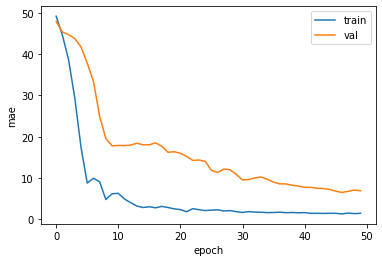

In [ ]:
model_3 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(96,96,1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(filters=96, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
  
    Flatten(),
    Dense(512, activation='relu'),
    Dense(8)
])

model_3.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])

history_3 = model_3.fit(mini_train_data, mini_train_labels, epochs=50, validation_split=0.1)

plt.plot(history_3.history['mae'], label='train')
plt.plot(history_3.history['val_mae'], label='val')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend()

## Model 4

Dropout(0.1)

Dropout is another regularization method used to prevent overfitting. It is a mask that nullifies the contribution of some features of the next layer and leaves all others unmodified.

Epoch 1/50
3/3 [==============================] - 2s 434ms/step - loss: 2157.4070 - mae: 39.7391 - val_loss: 583.1057 - val_mae: 21.9952
Epoch 2/50
3/3 [==============================] - 1s 387ms/step - loss: 732.6119 - mae: 22.6495 - val_loss: 1764.3262 - val_mae: 39.6414
Epoch 3/50
3/3 [==============================] - 1s 381ms/step - loss: 1112.8181 - mae: 30.5138 - val_loss: 950.8616 - val_mae: 28.5565
Epoch 4/50
3/3 [==============================] - 1s 384ms/step - loss: 396.1243 - mae: 15.5839 - val_loss: 220.6612 - val_mae: 12.3963
Epoch 5/50
3/3 [==============================] - 1s 389ms/step - loss: 353.1269 - mae: 14.0897 - val_loss: 865.5504 - val_mae: 27.6176
Epoch 6/50
3/3 [==============================] - 1s 380ms/step - loss: 380.8910 - mae: 16.3367 - val_loss: 850.6290 - val_mae: 27.0432
Epoch 7/50
3/3 [==============================] - 1s 380ms/step - loss: 256.7724 - mae: 12.6514 - val_loss: 362.1184 - val_mae: 16.2122
Epoch 8/50
3/3 [=============================

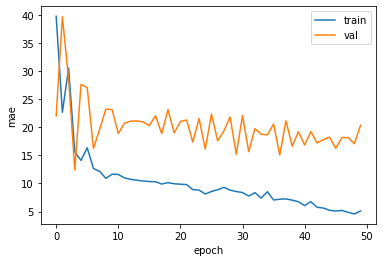

In [ ]:
model_4 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(96,96,1)),
    Dropout(.1),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    Dropout(.1),
    MaxPooling2D((2, 2)),

    Conv2D(filters=96, kernel_size=(3, 3), activation='relu'),
    Dropout(.1),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    Dropout(.1),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    Dropout(.1),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dense(8)
])

model_4.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])

history_4 = model_4.fit(mini_train_data, mini_train_labels, epochs=50, validation_split=0.1)

plt.plot(history_4.history['mae'], label='train')
plt.plot(history_4.history['val_mae'], label='val')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend()

## Model 5

Same as model 4 but with Dense layers added to each layer.

Epoch 1/50
3/3 [==============================] - 2s 460ms/step - loss: 2288.3411 - mae: 44.4388 - val_loss: 335.4240 - val_mae: 15.2343
Epoch 2/50
3/3 [==============================] - 1s 378ms/step - loss: 382.6825 - mae: 15.3200 - val_loss: 806.9748 - val_mae: 26.3284
Epoch 3/50
3/3 [==============================] - 1s 377ms/step - loss: 318.7822 - mae: 14.6073 - val_loss: 521.8475 - val_mae: 20.8398
Epoch 4/50
3/3 [==============================] - 1s 379ms/step - loss: 230.7071 - mae: 12.2402 - val_loss: 558.0638 - val_mae: 21.4294
Epoch 5/50
3/3 [==============================] - 1s 381ms/step - loss: 246.0987 - mae: 12.2584 - val_loss: 584.0008 - val_mae: 21.8380
Epoch 6/50
3/3 [==============================] - 1s 382ms/step - loss: 209.6670 - mae: 11.5685 - val_loss: 436.1974 - val_mae: 18.5163
Epoch 7/50
3/3 [==============================] - 1s 377ms/step - loss: 220.9293 - mae: 11.5157 - val_loss: 687.7816 - val_mae: 24.5360
Epoch 8/50
3/3 [==============================]

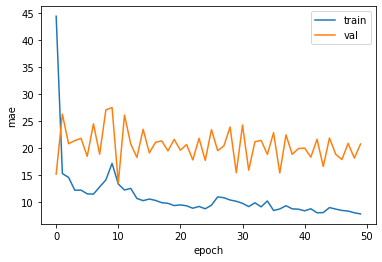

In [ ]:
model_5 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(96,96,1)),
    Dropout(.1),
    MaxPooling2D((2, 2)),
    Dense(30),
    
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    Dropout(.1),
    MaxPooling2D((2, 2)),
    Dense(30),

    Conv2D(filters=96, kernel_size=(3, 3), activation='relu'),
    Dropout(.1),
    MaxPooling2D((2, 2)),
    Dense(30),

    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    Dropout(.1),
    MaxPooling2D((2, 2)),
    Dense(30),

    Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    Dropout(.1),
    MaxPooling2D((2, 2)),
    Dense(30),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dense(8)
])

model_5.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])

history_5 = model_5.fit(mini_train_data, mini_train_labels, epochs=50, validation_split=0.1)

plt.plot(history_5.history['mae'], label='train')
plt.plot(history_5.history['val_mae'], label='val')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend()

## Model 6

Same as model 5 but with BatchNormalization added to each layer.

Epoch 1/50
3/3 [==============================] - 3s 702ms/step - loss: 1938.7018 - mae: 39.8772 - val_loss: 498.3170 - val_mae: 19.5444
Epoch 2/50
3/3 [==============================] - 2s 651ms/step - loss: 252.4712 - mae: 12.5232 - val_loss: 686.9178 - val_mae: 24.5296
Epoch 3/50
3/3 [==============================] - 2s 644ms/step - loss: 273.1969 - mae: 11.1260 - val_loss: 120.4170 - val_mae: 8.2528
Epoch 4/50
3/3 [==============================] - 2s 657ms/step - loss: 68.6279 - mae: 6.7970 - val_loss: 1289.5455 - val_mae: 30.9657
Epoch 5/50
3/3 [==============================] - 2s 646ms/step - loss: 74.1077 - mae: 6.6431 - val_loss: 2009.1387 - val_mae: 39.8439
Epoch 6/50
3/3 [==============================] - 2s 645ms/step - loss: 42.8810 - mae: 5.1950 - val_loss: 3242.5972 - val_mae: 50.5389
Epoch 7/50
3/3 [==============================] - 2s 651ms/step - loss: 31.8218 - mae: 4.5107 - val_loss: 3339.5261 - val_mae: 49.5499
Epoch 8/50
3/3 [==============================] - 2s

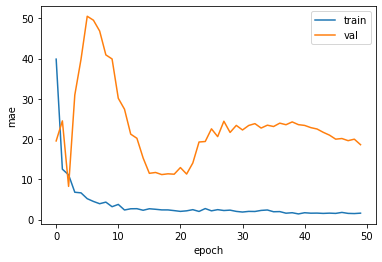

In [ ]:
model_6 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(96,96,1)),
    BatchNormalization(),
    Dropout(.1),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(.1),
    MaxPooling2D((2, 2)),

    Conv2D(filters=96, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(.1),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(.1),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(.1),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dense(8)
])
model_6.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])

history_6 = model_6.fit(mini_train_data, mini_train_labels, epochs=50, validation_split=0.1)

plt.plot(history_6.history['mae'], label='train')
plt.plot(history_6.history['val_mae'], label='val')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend()

## Model 7 
*same as Model 3 but with .add(LeakyReLU(alpha = 0.1))*

LeakyReLU is a leaky version of a Rectified Linear Unit. Essentially, it allows a small gradient when the unit is not active. 
```python
f(x) = alpha * x if x < 0
f(x) = x if x >= 0
```
In ReLU, the main drawback is that the input for the activation can be negative, causing the "Dying ReLU" problem, where the gradient is 0 whenever the unit is not active. This may lead to cases where a unit never activates since the gradient-based optimization algorithm will not adjust for weights of a unit that never activates initially. 

Therefore, the Leaky ReLU substitutes zero values with some small value alpha (ie. 0.1), creating a function:
```python
f(x) = max(0.1x, x)
```
The gradient descent of 0.1x now has non-zero values and will continue learning without reaching a dead end.

**References** \
https://stackoverflow.com/questions/64735352/details-about-alpha-in-tf-nn-leaky-relu-features-alpha-0-2-name-none
https://keras.io/api/layers/activation_layers/leaky_relu/ 

Epoch 1/50
3/3 [==============================] - 2s 497ms/step - loss: 2667.5862 - mae: 48.8533 - val_loss: 2405.6257 - val_mae: 46.3933
Epoch 2/50
3/3 [==============================] - 1s 438ms/step - loss: 2193.9478 - mae: 44.0550 - val_loss: 2152.3547 - val_mae: 43.8180
Epoch 3/50
3/3 [==============================] - 1s 438ms/step - loss: 1632.3934 - mae: 37.4607 - val_loss: 2162.0596 - val_mae: 43.8542
Epoch 4/50
3/3 [==============================] - 1s 439ms/step - loss: 977.0530 - mae: 27.4950 - val_loss: 2029.0984 - val_mae: 42.3378
Epoch 5/50
3/3 [==============================] - 1s 436ms/step - loss: 380.7701 - mae: 14.8044 - val_loss: 1833.5648 - val_mae: 40.0206
Epoch 6/50
3/3 [==============================] - 1s 431ms/step - loss: 131.5875 - mae: 9.5457 - val_loss: 1400.3217 - val_mae: 34.3007
Epoch 7/50
3/3 [==============================] - 1s 439ms/step - loss: 143.7473 - mae: 10.5311 - val_loss: 1077.3422 - val_mae: 29.5277
Epoch 8/50
3/3 [=======================

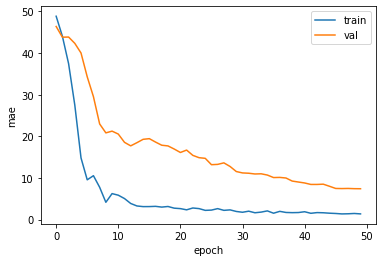

In [ ]:
model_7 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(96,96,1)),
    LeakyReLU(alpha = 0.1), 
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    LeakyReLU(alpha = 0.1), 
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(filters=96, kernel_size=(3, 3), activation='relu'),
    LeakyReLU(alpha = 0.1), 
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    LeakyReLU(alpha = 0.1), 
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    LeakyReLU(alpha = 0.1), 
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dense(8)
])

model_7.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])

history_7 = model_7.fit(mini_train_data, mini_train_labels, epochs=50, validation_split=0.1)

plt.plot(history_7.history['mae'], label='train')
plt.plot(history_7.history['val_mae'], label='val')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend()

## Model 8 
Same as Model 7 but with Dropout(0.1) after dense layer.

Epoch 1/50
3/3 [==============================] - 2s 500ms/step - loss: 2722.2617 - mae: 49.4966 - val_loss: 2391.2109 - val_mae: 46.4910
Epoch 2/50
3/3 [==============================] - 1s 435ms/step - loss: 2293.2251 - mae: 45.2951 - val_loss: 2047.8226 - val_mae: 42.7191
Epoch 3/50
3/3 [==============================] - 1s 440ms/step - loss: 1825.1847 - mae: 40.1840 - val_loss: 2066.3992 - val_mae: 42.8029
Epoch 4/50
3/3 [==============================] - 1s 439ms/step - loss: 1206.6726 - mae: 31.9713 - val_loss: 2076.9585 - val_mae: 42.8883
Epoch 5/50
3/3 [==============================] - 1s 441ms/step - loss: 568.2630 - mae: 20.2281 - val_loss: 2105.0503 - val_mae: 43.2002
Epoch 6/50
3/3 [==============================] - 1s 436ms/step - loss: 150.5232 - mae: 9.6083 - val_loss: 1739.9342 - val_mae: 39.0336
Epoch 7/50
3/3 [==============================] - 1s 435ms/step - loss: 117.9550 - mae: 9.1066 - val_loss: 1507.7845 - val_mae: 36.2409
Epoch 8/50
3/3 [=======================

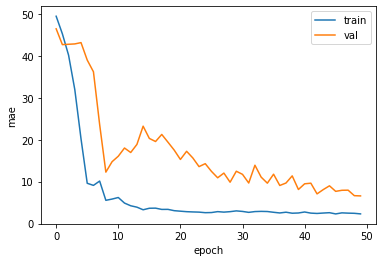

In [ ]:
model_8 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(96,96,1)),
    LeakyReLU(alpha = 0.1), 
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    LeakyReLU(alpha = 0.1), 
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(filters=96, kernel_size=(3, 3), activation='relu'),
    LeakyReLU(alpha = 0.1), 
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    LeakyReLU(alpha = 0.1), 
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    LeakyReLU(alpha = 0.1), 
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.1),
    Dense(8)
])

model_8.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])

history_8 = model_8.fit(mini_train_data, mini_train_labels, epochs=50, validation_split=0.1)

plt.plot(history_8.history['mae'], label='train')
plt.plot(history_8.history['val_mae'], label='val')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend()

### But, Leaky ReLU may not perform better than regular ReLU
We see that the performance of the two is almost the same, but the regular ReLU performs slightly better. This is because although LeakyReLU addresses the vanishing gradient problem, it introduces another hyperparameter (the slope). The hyperparameter may be tuned to squeeze a bit more performance from the model, but this comes at the cost of potential overfitting. Therefore, we have decided not to use LeakyReLU for our final model. 

**References** \
https://datascience.stackexchange.com/questions/74163/why-leaky-relu-is-not-so-common-in-real-practice

## Model Summary (on mini train)

| Model #      | Description.     | train_acc        | val_acc          |
| ------------ | ---------------- | ---------------- | ---------------- |
| 1      | first model         | 19.113 | nan |
| 2      | 2 Convolution + 1 Dense| 2.980 | 6.078 |
| 3      | 5 Convolution + 1 Dense (with batch norm) | 1.501 | 6.948 |
| 4      | same as model 3 except using .1 dropout  | 5.088  | 20.326 |
| 5      | same as model 4 with Dense layers       | 7.855  | 20.786 |
| 6      | same as model 5 with batchnorm           | 1.597 | 18.612 |
| 7      | same as model 3 with LeakyReLU          | 1.354  | 7.400 |
| 8      | same as model 7 with Dropout(0.1) in Dense layer   | 2.298  | 6.594 |

## Best model

Epoch 1/50
79/79 [==============================] - 53s 663ms/step - loss: 723.6896 - mae: 18.7040 - val_loss: 30012.0352 - val_mae: 157.9682
Epoch 2/50
79/79 [==============================] - 52s 663ms/step - loss: 35.2291 - mae: 4.1983 - val_loss: 46.1202 - val_mae: 5.3489
Epoch 3/50
79/79 [==============================] - 52s 664ms/step - loss: 27.2614 - mae: 3.8374 - val_loss: 39.6934 - val_mae: 4.6289
Epoch 4/50
79/79 [==============================] - 53s 665ms/step - loss: 25.6557 - mae: 3.7092 - val_loss: 27.5083 - val_mae: 3.9056
Epoch 5/50
79/79 [==============================] - 54s 677ms/step - loss: 27.2345 - mae: 3.8284 - val_loss: 22.4249 - val_mae: 3.4708
Epoch 6/50
79/79 [==============================] - 54s 684ms/step - loss: 25.4978 - mae: 3.6845 - val_loss: 66.9487 - val_mae: 6.0219
Epoch 7/50
79/79 [==============================] - 52s 664ms/step - loss: 27.0758 - mae: 3.8572 - val_loss: 46.0380 - val_mae: 5.0852
Epoch 8/50
79/79 [==============================

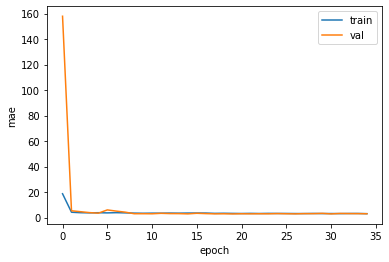

In [ ]:
best_model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(96,96,1)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(filters=96, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dense(8)
])

best_model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])

# stop early if not improving
EarlyStop_callback = EarlyStopping(patience=15, restore_best_weights=True)

best_history = best_model.fit(train_model_data, train_model_labels, batch_size=64, epochs=50, validation_split=0.1, 
                              callbacks=[EarlyStop_callback])

plt.plot(best_history.history['mae'], label='train')
plt.plot(best_history.history['val_mae'], label='val')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend()

In [ ]:
# print mae on test set
mae_test_total = []
for i, pred in enumerate(best_model.predict(test_model_data)):
    mae_test = mean_absolute_error(test_model_labels[i], pred)
    mae_test_total.append(mae_test)
print(np.mean(mae_test_total))

2.8970055141017044


See predictions on test images:

(1, 96, 96, 1)


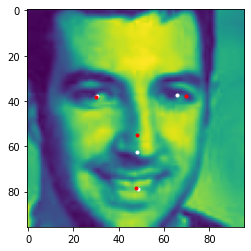

In [ ]:
img_num = 500
img = np.array([test_model_data[img_num]])
print(img.shape)

# plot predicted keypoints 
y_pred_keypoint = []
x_pred_keypoint = []
for i, pred in enumerate(best_model.predict(img)[0]):
    if i % 2 == 0: # even
        x_pred_keypoint.append(pred)
    else:
        y_pred_keypoint.append(pred)
plt.scatter(x_pred_keypoint, y_pred_keypoint, marker=".", color = 'white')

#plot actual keypoints
y_keypoint = []
x_keypoint = []
for i in range(8):
    if i % 2 == 0: # even
        x_keypoint.append(test_model_labels[img_num][i])
    else:
        y_keypoint.append(test_model_labels[img_num][i])
plt.scatter(x_keypoint, y_keypoint, marker=".", color = 'red')

plt.imshow(img.reshape(96, 96))

plt.show()

## Best model trained on entire training set

Epoch 1/50
99/99 [==============================] - 65s 653ms/step - loss: 617.0809 - mae: 16.9168 - val_loss: 2066.3770 - val_mae: 39.8301
Epoch 2/50
99/99 [==============================] - 64s 651ms/step - loss: 41.7076 - mae: 4.6326 - val_loss: 162.6208 - val_mae: 10.9583
Epoch 3/50
99/99 [==============================] - 65s 653ms/step - loss: 26.6282 - mae: 3.7581 - val_loss: 65.8526 - val_mae: 6.5727
Epoch 4/50
99/99 [==============================] - 65s 652ms/step - loss: 24.1903 - mae: 3.6209 - val_loss: 38.3685 - val_mae: 4.8050
Epoch 5/50
99/99 [==============================] - 64s 649ms/step - loss: 22.9612 - mae: 3.5305 - val_loss: 26.1482 - val_mae: 3.7382
Epoch 6/50
99/99 [==============================] - 64s 650ms/step - loss: 21.2102 - mae: 3.3769 - val_loss: 20.1627 - val_mae: 3.0218
Epoch 7/50
99/99 [==============================] - 65s 651ms/step - loss: 21.6567 - mae: 3.4298 - val_loss: 22.8276 - val_mae: 3.3160
Epoch 8/50
99/99 [==============================

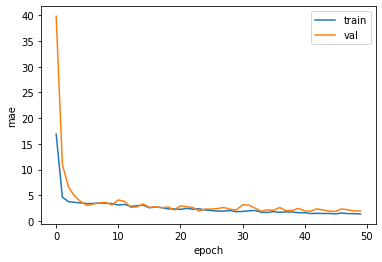

In [ ]:
best_model_full = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(96,96,1)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(filters=96, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dense(8)
])

best_model_full.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])

EarlyStop_callback = EarlyStopping(patience=15, restore_best_weights=True)

best_full_history = best_model_full.fit(train_data, train_labels, batch_size=64, epochs=50, validation_split=0.1, 
                              callbacks=[EarlyStop_callback])

plt.plot(best_full_history.history['mae'], label='train')
plt.plot(best_full_history.history['val_mae'], label='val')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend()

## See how the model performs on the test set

In [ ]:
# read in data
test = pd.read_csv("data/test.csv")

# transform all image data to correct shape
test_data = []
for img in test.Image:
    img = img.split()
    img = [int(i) for i in img]
    img = np.array(img)
    test_data.append(img.reshape(96, 96, 1))
test_data = np.array(test_data)

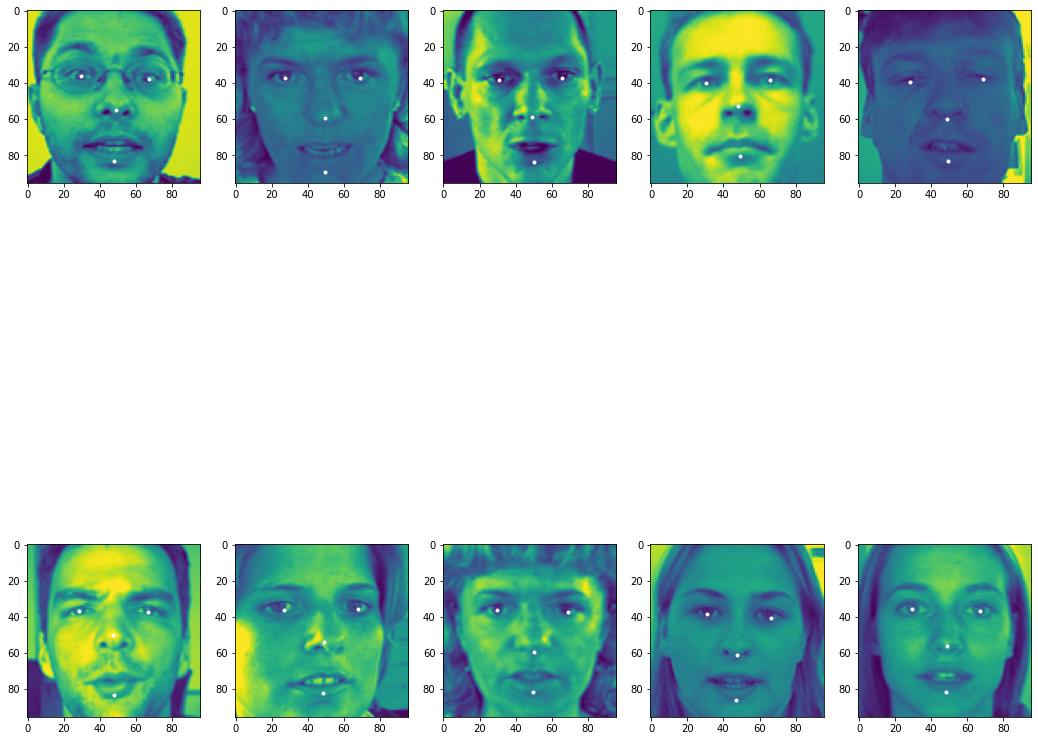

In [ ]:
images = np.array(test_data[:10])
fig, ax = plt.subplots(2, 5, figsize=(18,18))
best_model_full.predict(images)

for j, arr in enumerate(best_model_full.predict(images)):
    
    # plot predicted keypoints 
    y_pred_keypoint = []
    x_pred_keypoint = []
    for i, pred in enumerate(arr):
        if i % 2 == 0: # even
            x_pred_keypoint.append(pred)
        else:
            y_pred_keypoint.append(pred)
    ax[j//5][j%5].scatter(x_pred_keypoint, y_pred_keypoint, marker=".", color = 'white')
    ax[j//5][j%5].imshow(images[j].reshape(96, 96))

## Test on face of your choice!

In [ ]:
# import image and convert to pixel array
path = 'data/'
if len(path) > 5:
    pic = Image.open(path) # Can be many different formats.
    pic = ImageOps.grayscale(pic)
    pix = np.array(pic)
    img = np.array([pix.reshape(96, 96, 1)])

    # plot predicted keypoints 
    y_pred_keypoint = []
    x_pred_keypoint = []
    print(split_cnn.predict(img)[0])
    for i, pred in enumerate(cnn.predict(img)[0]):
        if i % 2 == 0: # even
            x_pred_keypoint.append(pred)
        else:
            y_pred_keypoint.append(pred)
    plt.scatter(x_pred_keypoint, y_pred_keypoint, marker=".", color = 'white')

    plt.imshow(img.reshape(96, 96))

#### Contributions: 
- Amy: background research, model research, CNN implementation, slides
- Gabriel: data proccessing, OLS implementation, slides
- Jeremy: model research, OLS implementation, CNN implementation, slides
- Shanie: data proccessing, OLS implementation, slides
- Simran: model research, CNN implementation, slides